<a href="https://colab.research.google.com/github/anas-awadalla/Incepto/blob/master/interpretability_experiments/ResNet_18_FAISS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/huyvnphan/PyTorch_CIFAR10.git

Cloning into 'PyTorch_CIFAR10'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 560 (delta 2), reused 4 (delta 2), pack-reused 551
Receiving objects: 100% (560/560), 6.55 MiB | 9.33 MiB/s, done.
Resolving deltas: 100% (184/184), done.


In [3]:
!python /content/cifar10_download.py

100% 2.46G/2.46G [03:33<00:00, 11.5MMiB/s]
Download successful. Unzipping file.
Unzip file successful!


In [4]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [10]:
from cifar10_models import *

# Pretrained model
model = resnet18(pretrained=True)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Get Convolutional Layers

In [6]:
model_children = list(model.children())
model_weights = []
conv_layers = []

# counter to keep count of the conv layers
counter = 0 

# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 17


In [13]:
# pass the image through all the layers
results = [conv_layers[0](ood_img.unsqueeze(0))]
for i in range(1, len(conv_layers)):
    # pass the result from the last layer to the next layer
    results.append(conv_layers[i](results[-1]))

# make a copy of the `results`
outputs = results

Layer Visualizations

In [9]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(30, 30))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        if i == 64: # we will visualize only 8x8 blocks from each layer
            break
        plt.subplot(8, 8, i + 1)
        plt.imshow(filter, cmap='gray')
        plt.axis("off")
    print(f"Saving layer {num_layer} feature maps...")
    plt.savefig("layer_"+str(num_layer)+".png")
    # plt.show()
    plt.close()

NameError: ignored

In [4]:
activation = {'conv1':0,'layer1':0,'layer2':0,'layer3':0,'layer4':0}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


model.conv1.register_forward_hook(get_activation('conv1'))
model.layer1.register_forward_hook(get_activation('layer1'))
model.layer2.register_forward_hook(get_activation('layer2'))
model.layer3.register_forward_hook(get_activation('layer3'))
model.layer4.register_forward_hook(get_activation('layer4'))

In [7]:
!pip install torchray

     |████████████████████████████████| 378kB 7.3MB/s 
  Created wheel for torchray: filename=torchray-1.0.0.2-cp36-none-any.whl size=444028 sha256=4b5c46df085334febd3193480c50dda1ed616ccbc0ac132498b892d62cc7843d
  Stored in directory: /root/.cache/pip/wheels/49/21/6d/e6794f79658b66a0775b164fdd274b81a4c96e4eab5baaacb0
Successfully built torchray


In [8]:
from torchray.attribution.extremal_perturbation import extremal_perturbation, contrastive_reward
from torchvision.utils import save_image
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

def perturbation(x,y, path, area=0.1):
  # Extremal perturbation
      masks_1,_ = extremal_perturbation(
          model.cuda(), x.cuda(), y,
          reward_func=contrastive_reward,
          perturbation="blur",
          debug=False,
          areas=[area],
          smooth=0.01,
          max_iter=800
      )
      ## Crop Important Area
      dat=torch.round(masks_1)[0].cpu().detach().numpy() # 'sharpen' mask
      true_points = np.argwhere(dat)

      if len(true_points) != 0:
        # take the smallest points and use them as the top left of your crop
        top_left = true_points.min(axis=0)
        # take the largest points and use them as the bottom right of your crop
        bottom_right = true_points.max(axis=0)

        x = x.squeeze()
        save_image(x,path)
        
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED)

        start_point = (top_left[1], top_left[2]) 
        end_point = (bottom_right[1], bottom_right[2]) 


        color = (255, 0, 0) 
        thickness = 2
        x = cv2.rectangle(img, start_point, end_point, (255, 0, 0), thickness)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)

        cv2.imwrite("img1.png",np.asarray(x))
        plt.imsave(path,x)
        return x
      else:
        return x.squeeze().cpu().numpy()

In [34]:
perturbation(ood_img.unsqueeze(0),4,"img.jpg")

array([[[ 31, 114, 216],
        [ 38, 124, 225],
        [ 47, 135, 233],
        ...,
        [125, 237, 251],
        [119, 230, 249],
        [115, 226, 245]],

       [[ 37, 120, 222],
        [ 43, 129, 230],
        [ 53, 141, 239],
        ...,
        [130, 240, 255],
        [124, 234, 251],
        [121, 231, 248]],

       [[ 46, 128, 230],
        [ 52, 135, 237],
        [ 60, 146, 245],
        ...,
        [136, 242, 255],
        [132, 238, 254],
        [129, 235, 251]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [ 50,  50,  38],
        [ 30,  28,  13],
        [ 10,   9,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [ 47,  45,  33],
        [ 24,  21,   4],
        [ 10,   8,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [ 21,  19,   6],
        [  4,   1,   0],
        [  4,   2,   0]]

In [7]:
from tqdm.notebook import tqdm
images = []
features = []
trans = transform=transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
dataset_imgs = torchvision.datasets.CIFAR10("/data/",download=True,train=False,transform=trans)
dataloader_imgs = torch.utils.data.DataLoader(dataset_imgs, batch_size=1)


toPil = transform=transforms.Compose([
        transforms.ToPILImage()
    ])

imgs = torchvision.datasets.CIFAR10("/data/",download=True,train=False,transform=transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor()
        ]))
imgs = torch.utils.data.DataLoader(imgs, batch_size=1)



Files already downloaded and verified
Files already downloaded and verified


In [8]:
!pip install faiss-cpu

In [9]:
import numpy as np
import faiss

In [10]:
images = []
targets = []
for img, target in tqdm(imgs):
      images.append(toPil(img.squeeze(0)))
      targets.append(target.item())

tensor([[3.5066e-04, 2.8936e-05, 6.2439e-03, 1.5059e-02, 9.6858e-01, 8.8906e-03,
         3.2720e-04, 2.3746e-04, 1.8966e-04, 8.8768e-05]],
       grad_fn=<SoftmaxBackward>)
Output:  4


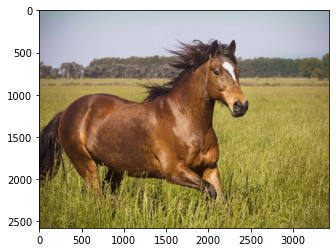

In [11]:
from matplotlib.pyplot import imshow
from PIL import Image
image_path = "/content/horse-galloping-in-grass-688899769-587673275f9b584db3a44cdf.jpg" #@param {type: "string"}
im = Image.open(image_path) 

ood_img = trans(im)

model.cpu().eval()
output = model(ood_img.unsqueeze(0))
print(torch.softmax(output,dim = 1))
print("Output: ", torch.argmax(output).item())
imshow(im)

In [13]:
overall_layer = float("-inf")
model.cuda()
model.eval()
for key in activation.keys():
    num_correct = 0
    count = 0
    features = []
    targets = []
    for (tensor, y) in tqdm(dataloader_imgs):
      output = model(tensor.cuda())
      targets.append(y.item())
      features.append(torch.flatten(activation[key]).cpu().detach().numpy())
      count+=1
      if(count == 100):
        break;

    D = len(features[0])
    N = len(features)

    # X = np.random.random((len(features), len(features[0]))).astype(np.float32)  # inputs of faiss must be float32

    X = np.asarray(features)

   
    index = faiss.IndexFlatL2(D)

    index.add(X)
  
    topk = 5

    ### In Distribution
    # test_output = model(trans(images[1]).unsqueeze(0).cuda())
    # search_query = np.asarray(X[1:2])
    # true_target = torch.argmax(test_output).item()

    # OOD Image
    test_output = model(ood_img.unsqueeze(0).cuda())
    test_features= torch.flatten(activation[key]).cpu().detach().numpy()
    search_query = np.asarray([test_features])

    true_target = torch.argmax(test_output).item()
    # print("Predicted Target ",true_target)

    dists, ids = index.search(x=search_query, k=topk)


    # total_dist = sum(dists[0])
    for i in ids[0]:
      if(targets[i] == true_target):
        num_correct +=1
      # print(targets[i])

    print(num_correct)
    
    print(dists)
    print(ids)


    if(num_correct > overall_layer):
      debug_imgs = ids[0]
      overall_layer = num_correct
      print("Chosen Layer ",key)
 



1
[[32493.055 40158.28  40617.93  41698.71  43271.42 ]]
[[36 24 27 69 31]]
Chosen Layer  conv1


1
[[1329.6334 1332.3333 1363.8398 1369.8765 1379.6365]]
[[55 69 85 94 34]]


1
[[174.44075 175.27399 178.85555 179.96667 181.1591 ]]
[[93 69 85 94 27]]


0
[[ 94.87048  97.13019 100.47879 103.3518  104.61194]]
[[62 69 49 44 93]]


0
[[16045.6455 20328.236  20412.2    21875.797  22609.488 ]]
[[62 69 49 44 29]]


In [14]:
from PIL import Image
num = 0
for i in debug_imgs:
  images[i].save("in-dist"+str(num)+".png")
  num+=1
  

In [23]:
from PIL import Image
num = 0
for i in debug_imgs:
  perturbation(trans(images[i]).unsqueeze(0),targets[i],"ood"+str(num)+".png")
  # images[i].save("ood"+str(num)+".png")
  num+=1

## Single Image High Resolution

In [ ]:
!git clone https://github.com/krasserm/super-resolution.git

In [ ]:
!cp -r super-resolution/model/ /content/
!cp super-resolution/utils.py /content/

In [ ]:
from model.srgan import generator
from utils import load_image, plot_sample
from model.common import resolve_single

model_hr = generator()
model_hr.load_weights('/content/drive/My Drive/Interpretability Experiments/srgan_weights/srgan/gan_generator.h5')

lr = load_image('image2.png')[:,:,:3]
sr = resolve_single(model_hr, lr)
print("Testing Single Image Super Resolution")
plot_sample(lr, sr)
